#  Enhancing Wi-Fi Networks with AI: A Deep Dive into Machine Learning for Wi-Fi Health Checks



## Introduction


In today's connected world, reliable Wi-Fi is crucial. But keeping it running smoothly can be tricky with all the potential issues like interference and signal drops. We're here to show you how AI, specifically supervised machine learning, can help spot and fix decrease of data ratefor a moving station. We'll walk you through how to build a model that detects performance drops in Wi-Fi networks, making network management more proactive and efficient.

Whether you're a tech expert or just curious about AI, this workshop will give you practical insights and hands-on experience. Let's dive in and explore how machine learning can make Wi-Fi better for everyone!



### Objectives
* Get Familiar with Supervised Learning: Learn the basics of supervised learning, including key concepts, algorithms, and how it's used to make predictions based on labeled data.

* Introduction to Time Series Modeling for Machine Learning: Gain a gentle introduction to time series modeling, exploring how to handle sequential data and apply it in a machine learning context.

* Apply Time Series Modeling to Detect Decreases in Data Rate: Discover practical applications by using time series modeling to identify and address drops in Wi-Fi performance, specifically focusing on detecting decreases in data rate.


### Data Generation

**TODO**: Murat to add the details of how data was generated

### PCAP Extraction process
To extract the content of the PCAP file we used the following command:

```
tshark -o 'gui.column.format:"cus.protocol","%p","Protocol","%p","cus.wlan.fc.type","%Cus:wlan.fc.type:0:R","cus.wlan.fc.type_subtype","%Cus:wlan.fc.type_subtype:0:R","cus.wlan.ssid","%Cus:wlan.ssid:0:R"' \
-T fields \
-e _ws.col.cus.protocol \
-e _ws.col.Protocol \
-e frame.protocols \
-e frame.number \
-e frame.time_epoch \
-e wlan.fc.type \
-e _ws.col.cus.wlan.fc.type \
-e wlan.fc.type_subtype \
-e _ws.col.cus.wlan.fc.type_subtype \
-e wlan.ssid \
-e _ws.col.cus.wlan.ssid \
-e wlan.tag \
-e wlan.bssid \
-e wlan.sa \
-e wlan.da \
-e wlan.ra \
-e wlan.ta \
-e wlan_radio.channel \
-e wlan_radio.signal_dbm \
-e wlan_radio.data_rate \
-e wlan.rsn.capabilities \
-e wlan.rsn.akms.list \
-e wlan.rsn.pcs.list \
-e wlan.qos.tid \
-e radiotap.channel.freq \
-e radiotap.dbm_antsignal \
-e radiotap.datarate \
-e wlan.addr \
-e wlan.seq \
-e wlan.fc.retry \
-e wlan.fc.retry.expert \
-e radiotap.data_retries \
-e wlan.duration \
-e wlan.qbss.cu \
-e radiotap.quality \
-e wlan_radio.signal_percentage \
-e wlan.fcs \
-e wlan.fcs.status \
-e wlan.fc \
-e wlan.fc.moredata \
-e frame.len \
-e wlan_radio.duration \
-e frame.cap_len \
-e wlan.qos.priority \
-e wlan.qos.ack \
-e wlan.qos.buf_state_indicated \
-e wlan_radio.noise_dbm \
-e tcp.analysis.ack_rtt \
-e tcp.analysis.lost_segment \
-e tcp.analysis.retransmission \
-e frame.time_delta \
-e wlan_radio.snr \
-e wlan.fc.more_fragments \
-e wlan.fixed.ssc.fragment \
-e wlan.fragment \
-e wlan.fragment.count \
-e wlan.fragment.error \
-e wlan_radio.frequency \
-e radiotap.present.db_antnoise \
-e radiotap.present.db_antsignal \
-e radiotap.present.dbm_antnoise \
-e radiotap.present.dbm_antsignal \
-E aggregator="$" \
-E separator=/t \
-E header=y \
-r 'wifi_file.pcap' \
-w 'output_file.csv'
```


where `wifi_file.pcap` is the PCAP file and `output.csv` is csv structured output that we will use.

## Pre-processing of data

In [1]:
try:
    import google.colab
    from google.colab import output
    # output.enable_custom_widget_manager()         # Enable custom widgets in Colab for profile reports
    IN_COLAB = True
    # Load the autoreload extension for IPython
    %load_ext autoreload
    # Set the autoreload extension to reload modules every time they are imported, so that changes made to code in the src folder are reflected in the running code
    %autoreload 2

    %pip install ydata_profiling==4.8.3 \
            scikit-learn==1.5.0 \
            itables==2.1.0 \
            ipywidgets==8.1.2 \
            numpy==1.24.1

except:
    IN_COLAB = False

In [2]:
# Import relevant python libraries

import os                       # Interact with the operating system
import pandas as pd             # Data analysis and manipulation
import numpy as np              # Numerical operations on arrays
import matplotlib.pyplot as plt         # Create plots
from itables import show                # To create interactive tables
from ydata_profiling import ProfileReport     # Generate data profile reports
import zipfile

In [3]:
%%time
# Loading data from remote repository
import os
from zipfile import ZipFile
from ipywidgets import interact

try:
    import google.colab
    from google.colab import output
    output.enable_custom_widget_manager()         # Enable custom widgets in Colab for profile reports
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
  # Define the URL of the zip file
  url = "https://github.com/b-yond-infinite-network/sharkfest-us-2024/raw/main/data/wifi-health-checks-data.zip"

  # Define the local file path where the zip file will be saved
  data_path = "/content/wifi-health-checks-data.zip"
  local_extract_path ="/content/tmp"

  # Download the zip file using wget
  !wget -O {data_path} {url}

  # Confirm the download location
  print(f"Zip file downloaded to: {local_extract_path}")
else:
  # Define the path of the zip file
  data_path = "../data/wifi-health-checks-data.zip"
  local_extract_path = "../data/tmp"

# Extract the zip file
with ZipFile(data_path) as zip_file:
    zip_file.extractall(local_extract_path)

# Collect the list of CSV file paths
files = [os.path.join(local_extract_path, file_name) for file_name in os.listdir(local_extract_path) if file_name.endswith('.csv')]
files.sort()

# choose the file from a dropdown list inside the notebook
df = None
def load_file(file):
    """
    Load the file into a dataframe and display the info
    """
    global df
    df = pd.read_csv(file)
    return df.info()

interact(load_file, file=files)

--2024-06-06 18:05:55--  https://github.com/b-yond-infinite-network/sharkfest-us-2024/raw/main/data/wifi-health-checks-data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/b-yond-infinite-network/sharkfest-us-2024/main/data/wifi-health-checks-data.zip [following]
--2024-06-06 18:05:56--  https://raw.githubusercontent.com/b-yond-infinite-network/sharkfest-us-2024/main/data/wifi-health-checks-data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4460804 (4.3M) [application/zip]
Saving to: ‘/content/wifi-health-checks-data.zip’

/content/wifi-healt 100%[===================>]   4.25M  --.-KB/

interactive(children=(Dropdown(description='file', options=('/content/tmp/file-logDistance-exp3dot5-nt-91dBm-f…

CPU times: user 562 ms, sys: 164 ms, total: 726 ms
Wall time: 2.15 s


<function __main__.load_file(file)>

### Functions to preprocess the data
For each file we will:
* remove the empty columns
* change epoch times ('frame_time_epoch') to timestamps
* filter the rows with specific source address and keep only data frames
* index the file by the timestamps

In [4]:
# function to convert epoch times to datetime
def convert_epoch_to_datetime(df):
    df['timestamps'] = pd.to_datetime(df['frame_time_epoch'], unit='s')
    return df

# function to select frames with 'wlan_fc_type' == 2 and 'wlan_sa' is not 'source_address'
def select_frames(df, source_address):
    return df[(df['wlan_fc_type'] == 2) & (df['wlan_sa'] != source_address)]  # Is this the right way?

# function to remove empty columns
def remove_empty_columns(df):
    return df.dropna(axis=1, how='all')

def preprocess(df, source_address):
    res = convert_epoch_to_datetime(df)
    res = select_frames(res,source_address)
    res = remove_empty_columns(res)
    return res


# Lets apply the preprocessing function to the df we created earlier
source_address = '00:00:00:00:00:02'  #this is the client address. we don't want packets where it is the source address
df = preprocess(df, source_address)
df.info()       # check the column names and their data types


# Observations
# - The number of columns have been reduced
# - The 'timestamps' column is added at the end
# - The number of rows reduced

<class 'pandas.core.frame.DataFrame'>
Index: 3881 entries, 4857 to 9107
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   _ws_col_cus_protocol              3881 non-null   object        
 1   _ws_col_protocol                  3881 non-null   object        
 2   frame_protocols                   3881 non-null   object        
 3   frame_number                      3881 non-null   int64         
 4   frame_time_epoch                  3881 non-null   float64       
 5   wlan_fc_type                      3881 non-null   int64         
 6   _ws_col_cus_wlan_fc_type          3881 non-null   object        
 7   wlan_fc_type_subtype              3881 non-null   object        
 8   _ws_col_cus_wlan_fc_type_subtype  3881 non-null   object        
 9   wlan_bssid                        3881 non-null   object        
 10  wlan_sa                           3881 non-null   

In [5]:
%%time

# Let us now analyze the data statistically using ydata_profiling library
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

# Define the report path
report_path = "./output/report/analysis_report.html"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(report_path), exist_ok=True)

# we can save the analysis in the drive
profile.to_file(report_path)


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/describe_date_pandas.py:44: UserWarning: Discarding nonzero nanoseconds in conversion.
  "min": pd.Timestamp.to_pydatetime(series.min()),
/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/describe_date_pandas.py:45: UserWarning: Discarding nonzero nanoseconds in conversion.
  "max": pd.Timestamp.to_pydatetime(series.max()),
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 17s, sys: 27.2 s, total: 1min 44s
Wall time: 1min 56s


### Function to resample the data

The Objective is to resample the data to a specific time interval.

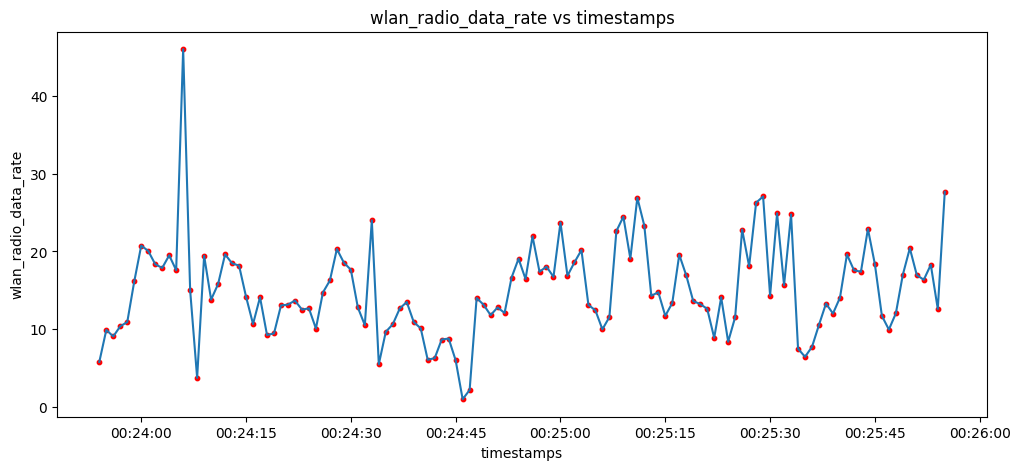

In [17]:
# create a function which also takes sampling time as input
def resample_file(df, step_size):

    # if the columns exists, set index, if not, it has already been set
    if 'timestamps' in df.columns:
        df.set_index('timestamps', inplace=True)    #set index to timestamps

    #resample data and fill missing values with previous values
    df = df.resample(f'{step_size}s').mean(numeric_only=True).ffill()

    # the first row is NaN, so we drop it
    df = df.dropna(how = 'all')

    return df

# Test the function, resample the data and plot to analyze
step_size = 1
resampled_df = resample_file(df, step_size)

# Let's plot the 'wlan_radio_data_rate' vs timestamps
plt.figure(figsize=(12, 5))
plt.plot(resampled_df.index, resampled_df['wlan_radio_data_rate'])
plt.scatter(resampled_df.index, resampled_df['wlan_radio_data_rate'], color='red', s=10)
plt.xlabel('timestamps')
plt.ylabel('wlan_radio_data_rate')
plt.title('wlan_radio_data_rate vs timestamps')
plt.show()


## Model Development and Evaluation

### Feature Creation
The idea is to create a set of features using the past history of the data. We will use our variable of interest `wlan_radio_datarate` and its past values to create the features.

In [7]:
# create a function to create features from the 'wlan_radio_data_rate' column
def create_features(df, past_history_sec):

    # convert past_history from seconds to number of samples, based on the resampling time
    past_history_samples = int(past_history_sec / step_size)
    df = df.copy()
    for i in range(1, past_history_samples+1):
        df[f'data_rate_lag_{i}'] = df['wlan_radio_data_rate'].shift(i)

    # remove initial rows with NaN values in the new columns
    df = df.iloc[past_history_samples:]

    return df

# Test the function, create features and plot to analyze
past_history_sec = 15  #seconds

df = create_features(resampled_df, past_history_sec)
show(df)

In [8]:
%%time

# Let us now analyze the data statistically using ydata_profiling library
profile2 = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

# Define the report path
report_path2 = "./output/report/analysis_report2.html"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(report_path2), exist_ok=True)

# we can save the analysis in the drive
profile.to_file(report_path2)


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 213 ms, sys: 14.8 ms, total: 228 ms
Wall time: 499 ms


In [27]:
# Lets do all of the above steps on all the files in the folder in a loop and then save the results in a big dataframe

df_complete = pd.DataFrame()

# Select the step size and past history
step_size = 1
past_history = 15

past_history_samples = int(past_history_sec / step_size)

for file in files:
    df = pd.read_csv(file)
    df = preprocess(df, source_address)
    df = resample_file(df, step_size)

    df = create_features(df, past_history)

    df_complete = pd.concat([df_complete, df])

show(df_complete)

### The ML Process
<img src="https://github.com/b-yond-infinite-network/sharkfest-us-2024/blob/main/assets/ml_process.jpg?raw=1">

### Evaluation Metrics
<img src="https://github.com/b-yond-infinite-network/sharkfest-us-2024/blob/main/assets/confusion_matrix.png?raw=1">

<img src="https://github.com/b-yond-infinite-network/sharkfest-us-2024/blob/main/assets/precision_recall.jpg?raw=1">

also references.
refer to further reading.  


In [28]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# create a list of feature names to select from the dataframe
features = [f'data_rate_lag_{i}' for i in range(past_history_samples, 0, -1)]

features.append('wlan_radio_data_rate')

target = 'label'

X = df_complete[features]
y = df_complete[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=20,
                                                    shuffle=False
                                                    )

#  random forest classifier
rf = RandomForestClassifier(
                            class_weight= 'balanced',
                            random_state=20
                            )
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

CPU times: user 853 ms, sys: 2.12 ms, total: 855 ms
Wall time: 853 ms


Overall accuracy', 0.679
Precision: 0.382
Recall: 0.812
F1: 0.519
CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.93      0.64      0.76       431
         1.0       0.38      0.81      0.52       117

    accuracy                           0.68       548
   macro avg       0.65      0.73      0.64       548
weighted avg       0.81      0.68      0.71       548

CPU times: user 143 ms, sys: 44.7 ms, total: 188 ms
Wall time: 136 ms


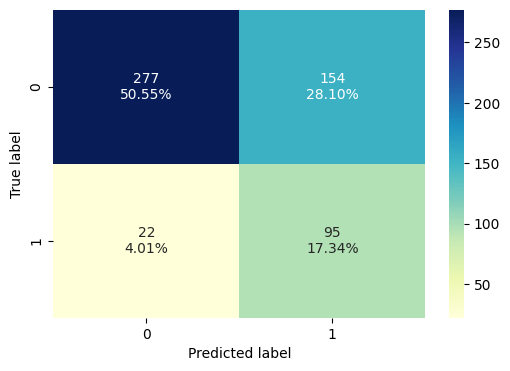

In [29]:
%%time
# Evaluation of the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(y_test, y_predict):

    print("Overall accuracy', %.3f" %accuracy_score(y_test, y_predict))
    precision = precision_score(y_test, y_predict)
    print('Precision: %.3f' % precision)

    recall = recall_score(y_test, y_predict)
    print('Recall: %.3f' % recall)

    f1 = f1_score(y_test, y_predict, average='binary')
    print('F1: %.3f' % f1)

    print("CLASSIFICATION REPORT")
    print(classification_report(y_test, y_predict))

    cm = confusion_matrix(y_test, y_predict)

    labels = np.asarray(
        [ ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten() ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="", cmap="YlGnBu")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# call the function
evaluate_model(y_test, y_pred)

## Model Optimization

We will optimize this model at two levels:

First by changing the threshold that separates the positive and negative classes, then by modifying the `step_size` and `past_history` parameters

Best threshold: 0.7
Overall accuracy', 0.896
Precision: 0.763
Recall: 0.744
F1: 0.753
CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       431
         1.0       0.76      0.74      0.75       117

    accuracy                           0.90       548
   macro avg       0.85      0.84      0.84       548
weighted avg       0.90      0.90      0.90       548

CPU times: user 14.1 s, sys: 96.9 ms, total: 14.2 s
Wall time: 14.2 s


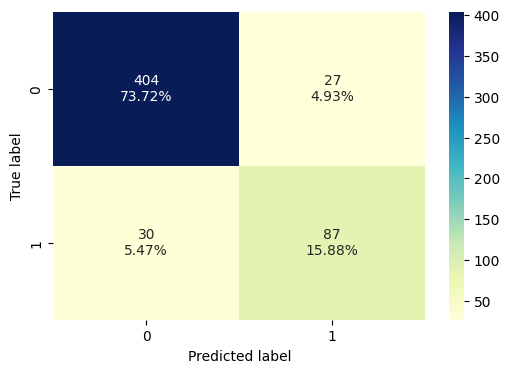

In [30]:
%%time
# Find the best threshold for the model

from sklearn.model_selection import FixedThresholdClassifier

thresholds = np.arange(0.2, 0.9, 0.05)

def find_best_threshold(classifier, X_train, y_train, X_test, y_test, thresholds):

    results = []

    for threshold in thresholds:
        rf_improved = FixedThresholdClassifier(classifier, threshold=threshold)
        y_pred = rf_improved.fit(X_train, y_train).predict(X_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')

        # if any of the precision or recall is zero, skip the threshold. sklearn sets them to zero when their denominator is zero
        if precision == 0 or recall == 0:
            continue

        results.append([threshold, precision, recall, f1])

    results = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1_score'])
    results['diff_pre_rec'] = abs(results['precision'] - results['recall'])

    # find the threshold with the minimum difference between precision and recall
    best_threshold = results.loc[results['diff_pre_rec'].idxmin()]

    # train the model with the best threshold and return it
    best_model = FixedThresholdClassifier(classifier, threshold=best_threshold['threshold'])

    return best_threshold, best_model

# # Call the function
# best_threshold, best_model = find_best_threshold(rf, X_train, y_train, X_test, y_test, thresholds)
# print('Best threshold:', best_threshold['threshold'])
# best_model.fit(X_train, y_train)

# # Evaluate the model with the best threshold
# y_pred = best_model.predict(X_test)
# evaluate_model(y_test, y_pred)


In [35]:
## Iteratively testing various step size and past history values to optimize model performance
%%time
step_size_vals = [1, 2, 3, 5]
past_history_vals = [5, 10, 15, 20, 25]

# Load and preprocess the CSV files outside the inner loop
wifi_data_list = []

for file in files:
    df = pd.read_csv(file)
    df = preprocess(df, source_address)
    wifi_data_list.append(df)

# Loop over the step size and history values
final_results = []
for step_size in step_size_vals:

    for past_history in past_history_vals:

        print(f'Resampling time: {step_size}, Window size: {past_history}...')

        # if the window size is less than the resampling time, skip the iteration
        if past_history < step_size:
            continue

        past_history_samples = int(past_history / step_size)

        wifi_data = pd.DataFrame()

        for df in wifi_data_list:
            resampled_df = resample_file(df, step_size)
            features_df = create_features(resampled_df, past_history)
            wifi_data = pd.concat([wifi_data, features_df])

        # create a list of features to select from the dataframe
        features = [f'data_rate_lag_{i}' for i in range(past_history_samples, 0, -1)]
        features.append('wlan_radio_data_rate')

        X = wifi_data[features]
        y = wifi_data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=10,
                                                            shuffle=False
                                                            )

        model = RandomForestClassifier(class_weight= 'balanced',
                                    random_state=20
                                    )
        model.fit(X_train, y_train)

        # finding an optimal threshold value for the model
        best_threshold, best_model = find_best_threshold(model, X_train, y_train, X_test, y_test, thresholds)

        # select the best model metrics and store them
        precision = best_threshold['precision']
        recall = best_threshold['recall']
        f1 = best_threshold['f1_score']

        final_results.append([step_size, past_history, precision, recall, f1, model, X_test, y_test])

final_results = pd.DataFrame(final_results, columns=['step_size', 'past_history', 'precision', 'recall', 'f1_score', 'model', 'X_test', 'y_test'])


Resampling time: 1, Window size: 5...
Resampling time: 1, Window size: 10...
Resampling time: 1, Window size: 15...
Resampling time: 1, Window size: 20...
Resampling time: 1, Window size: 25...
Resampling time: 2, Window size: 5...
Resampling time: 2, Window size: 10...
Resampling time: 2, Window size: 15...
Resampling time: 2, Window size: 20...
Resampling time: 2, Window size: 25...
Resampling time: 3, Window size: 5...
Resampling time: 3, Window size: 10...
Resampling time: 3, Window size: 15...
Resampling time: 3, Window size: 20...
Resampling time: 3, Window size: 25...
Resampling time: 5, Window size: 5...
Resampling time: 5, Window size: 10...
Resampling time: 5, Window size: 15...
Resampling time: 5, Window size: 20...
Resampling time: 5, Window size: 25...
CPU times: user 2min 43s, sys: 1.12 s, total: 2min 44s
Wall time: 2min 58s


In [32]:
# Identify the best-performing combination
best_result = final_results.loc[final_results['f1_score'].idxmax()]

# Extract the best step_size, past_history, X_test, and y_test
step_size = best_result['step_size']
past_history = best_result['past_history']
X_test = best_result['X_test']
y_test = best_result['y_test']

print(f'Best Step Size: {step_size}, Best Past History: {past_history}')

Best Step Size: 3, Best Past History: 20


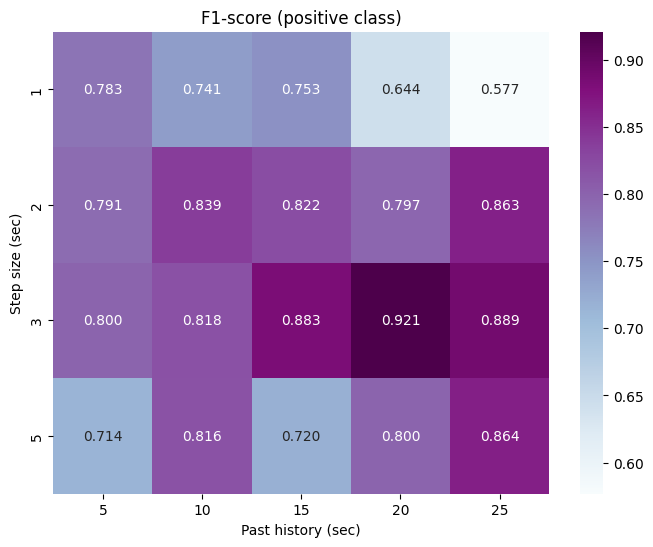

In [33]:
# Plot the results for all combinations of step size and history
df_plot = final_results.pivot(index='step_size', columns='past_history', values='f1_score')

plt.figure(figsize=(8, 6))
sns.heatmap(df_plot, annot=True, fmt=".3f", cmap="BuPu")
plt.ylabel("Step size (sec)")
plt.xlabel("Past history (sec)")
plt.title("F1-score (positive class)")
plt.show()

<!-- take examples.  -->


## Application of the optimized model

<ipython-input-34-0b1a9ddf579f>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(X_test.columns, rotation=45)


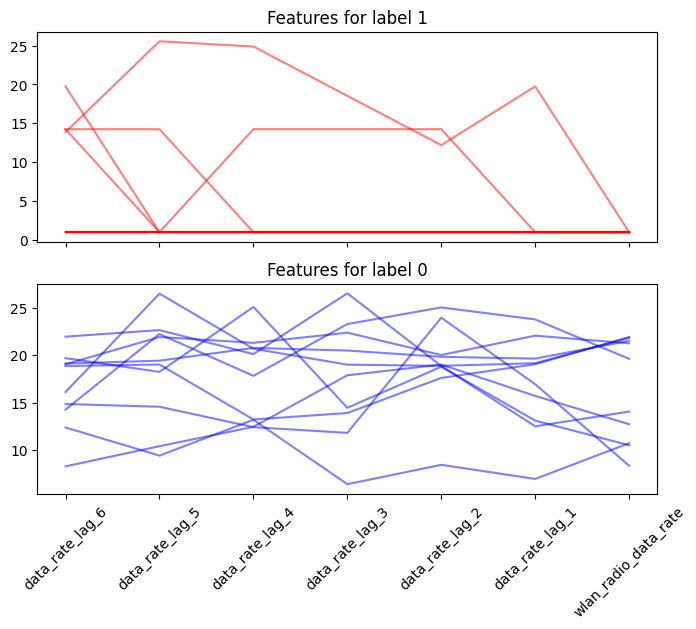

In [34]:
positive_indices = y_test[y_test == 1].sample(10, random_state=10).index
negative_indices = y_test[y_test == 0].sample(10, random_state=10).index

# Create a figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
# Plot positive_indices in red
axs[0].plot(X_test.loc[positive_indices].T, 'r', alpha=0.5)
axs[0].set_title('Features for label 1')
axs[0].set_xticklabels([])

# Plot negative_indices in blue
axs[1].plot(X_test.loc[negative_indices].T, 'b', alpha=0.5)
axs[1].set_title('Features for label 0')
axs[1].set_xticklabels(X_test.columns, rotation=45)

plt.show()


# Conclusion

In this workshop, we covered:
- How to process wifi data for a prediction model including handling missing values, duplicates, and irrelevant entries
- The importance of resampling data to ensure consistency in time intervals for time-series analysis.
- How to create time-series features from our data.
- The steps involved in training a machine learning model using the generated features and evaluating its performance.
- The significance of analyzing the effect of different parameters, such as resampling time intervals and window sizes, on the model's performance and generalization ability.

# Future direction

@Murat